In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

# Data cleaning
EDA
Topic Modeling
Classification & Parameter tuning
Regularized logistic regression
XGBoost
Class imbalance: class weighting vs SMOTE
Select best model + predict on test set

In [3]:
fake_job_postings = pd.read_csv('fake_job_postings.csv')

In [4]:
fake_job_postings.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
fake_job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [6]:
fake_job_postings.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
fake_job_postings.location = fake_job_postings.location.fillna('blank')

In [8]:
fake_job_postings_US = fake_job_postings[fake_job_postings['location'].str.contains("US")]

In [9]:

loc_split =[]
for loc in fake_job_postings_US.location:
    loc_split.append(loc.split(','))

loc_split = pd.DataFrame(loc_split)

loc_split = loc_split[[1, 2]]

loc_split = loc_split.rename(columns={1: "state", 2:'city'})

In [10]:
len(fake_job_postings_US)/len(fake_job_postings)

0.5959731543624162

In [11]:

fake_job_postings_US = fake_job_postings_US.reset_index()

In [12]:
fake_job_postings_US = fake_job_postings_US.join(loc_split)

In [13]:
fake_job_postings_US = fake_job_postings_US[['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'state', 'city']]

In [14]:

fake_job_postings_US = fake_job_postings_US[fake_job_postings_US['city'].notna()]
fake_job_postings_US = fake_job_postings_US[fake_job_postings_US['state'].notna()]

In [15]:
fake_job_postings_US.shape

(10593, 20)

In [16]:
fake_job_postings_US['state_city'] = fake_job_postings_US['state'] + ", " + fake_job_postings_US['city']

In [17]:
fake_job_postings_US.isna().sum()

job_id                    0
title                     0
location                  0
department             7567
salary_range           9064
company_profile        2037
description               0
requirements           1744
benefits               4638
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        1754
required_experience    4267
required_education     4460
industry               2672
function               3889
fraudulent                0
state                     0
city                      0
state_city                0
dtype: int64

In [18]:
fake_job_postings_US.city = fake_job_postings_US.city.str.strip()
fake_job_postings_US.state = fake_job_postings_US.state.str.strip()

In [19]:
fake_job_postings_US

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,state,city,state_city
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,...,0,Other,Internship,NaN,NaN,Marketing,0,NY,New York,"NY, New York"
1,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,...,0,NaN,NaN,NaN,NaN,NaN,0,IA,Wever,"IA, Wever"
2,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,DC,Washington,"DC, Washington"
3,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,FL,Fort Worth,"FL, Fort Worth"
4,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,...,0,NaN,NaN,NaN,NaN,NaN,0,MD,,"MD,"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10651,17873,Product Manager,"US, CA, San Francisco",Product Development,NaN,Flite delivers ad innovation at scale to the w...,Flite's SaaS display ad platform fuels the wor...,BA/BS in Computer Science or a related technic...,Competitive baseAttractive stock option planMe...,0,...,0,Full-time,NaN,NaN,Internet,Product Management,0,CA,San Francisco,"CA, San Francisco"
10652,17874,Recruiting Coordinator,"US, NC, Charlotte",NaN,NaN,NaN,RESPONSIBILITIES:Will facilitate the recruitin...,REQUIRED SKILLS:Associates Degree or a combina...,NaN,0,...,0,Contract,NaN,NaN,Utilities,NaN,0,NC,Charlotte,"NC, Charlotte"
10653,17875,JavaScript Developer,"US, ,",NaN,80000-100000,NaN,"Sr, JavaScript Developer Experience : 4-10 yea...",NaN,NaN,0,...,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Information Technology,0,,,","
10654,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,PA,Philadelphia,"PA, Philadelphia"


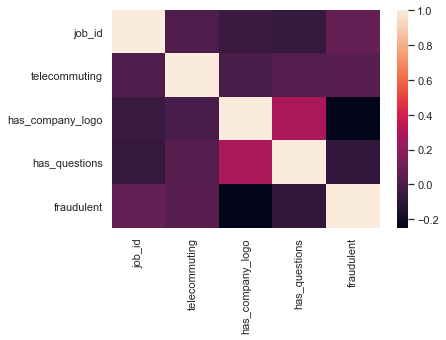

In [20]:
corr = fake_job_postings_US.corr()
sns.heatmap(corr)
plt.show()

In [21]:
len(fake_job_postings_US[fake_job_postings_US.fraudulent == 0]), len(fake_job_postings_US[fake_job_postings_US.fraudulent == 1]), 

(9868, 725)

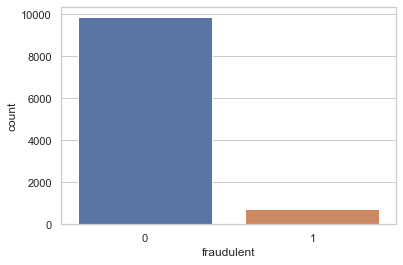

In [22]:
sns.countplot(x='fraudulent', data=fake_job_postings_US);

In [23]:
def sns_countplot(feature):
    sns.countplot(x=feature, data=fake_job_postings_US, hue="fraudulent",
              order=fake_job_postings_US[feature].value_counts().iloc[:10].index)
    plt.xticks(rotation=90)
    title = feature + ' fake job count'
    plt.title('Location Fake Jobs')
    plt.show()

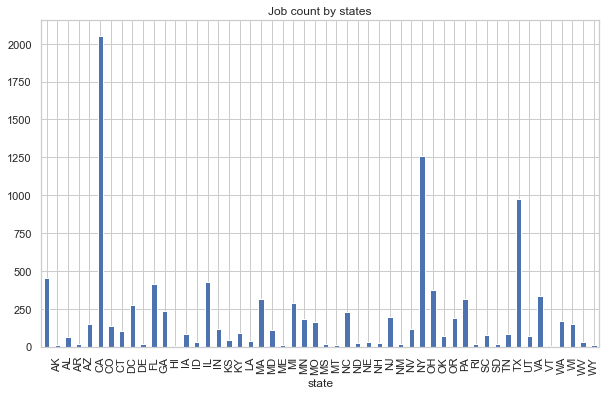

In [24]:
plt.figure(figsize=(10,6))
fake_job_postings_US.groupby('state').fraudulent.count().plot(kind='bar', title='Job count by states');

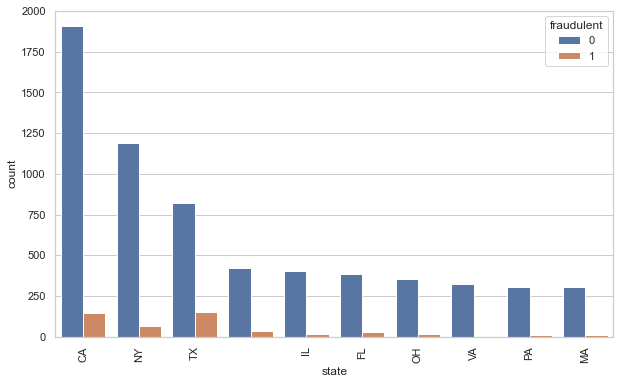

In [25]:
plt.figure(figsize=(10,6))
sns.countplot(x='state', data=fake_job_postings_US, hue="fraudulent", order=fake_job_postings_US['state'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.show()

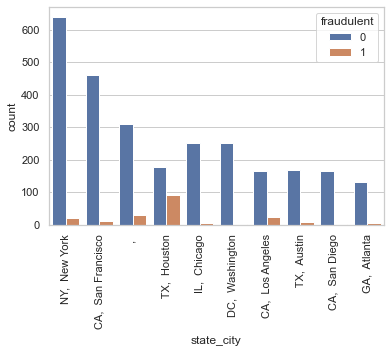

In [26]:
sns.countplot(x='state_city', data=fake_job_postings_US, hue="fraudulent", order=fake_job_postings_US['state_city'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.show()

In [27]:
def sns_countplot(feature):
    sns.countplot(x=feature, data=fake_job_postings_US, hue="fraudulent",
              order=fake_job_postings_US[feature].value_counts().iloc[:10].index)
    plt.xticks(rotation=90)
    title = feature + ' fake job count'
    plt.title(title)
    plt.show()

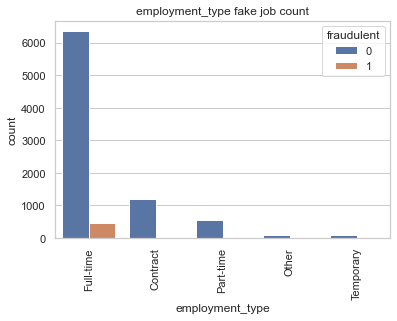

In [28]:
sns_countplot('employment_type');

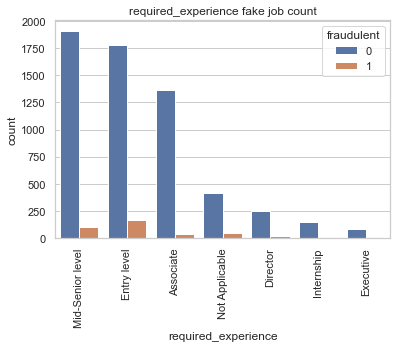

In [29]:
sns_countplot('required_experience');


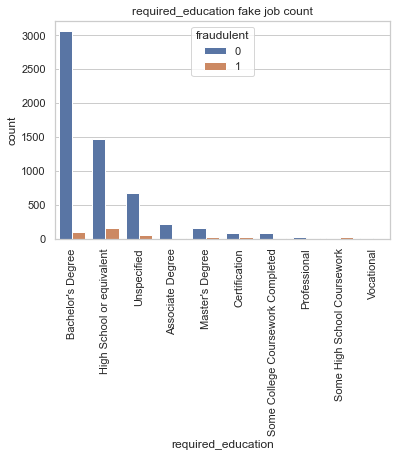

In [30]:
sns_countplot('required_education');

In [31]:
location_ratio = round(fake_job_postings_US[fake_job_postings_US.fraudulent == 1].groupby('state_city').state_city.count()/fake_job_postings_US[fake_job_postings_US.fraudulent == 0].groupby('state_city').state_city.count(), 2)
location_ratio = pd.DataFrame({'state_city':location_ratio.index, 'ratio':location_ratio.values})

In [32]:
fake_job_postings_US = fake_job_postings_US.merge(location_ratio)

In [33]:
fake_job_postings_US.ratio.fillna(0, inplace=True)

In [34]:
location_ratio_plot = location_ratio[location_ratio.ratio >= 1]

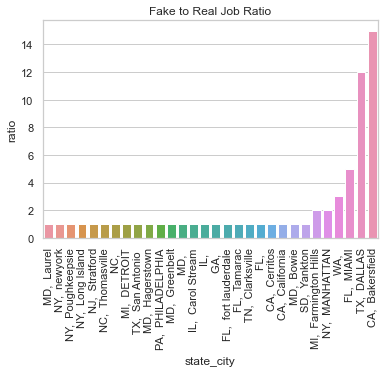

In [35]:
sns.barplot(data=location_ratio_plot.sort_values(by='ratio'), x='state_city', y='ratio')
plt.xticks(rotation=90)
plt.title('Fake to Real Job Ratio')
plt.show()

In [36]:
def missing_count(feature, title='None'):
    y_axis = fake_job_postings_US[fake_job_postings_US[feature].isna()][['fraudulent', feature]]
    y_axis = y_axis.fraudulent.value_counts()
    y_axis.plot(kind='bar')
    plt.ylabel('Count')
    plt.xlabel('Category')
    title = "Number of empty " + title + " in fraudulent and non-fraudulent"
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()
    return 0

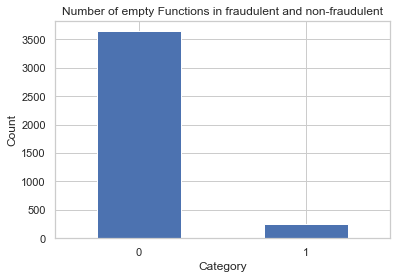

0

In [37]:
missing_count('function', 'Functions')

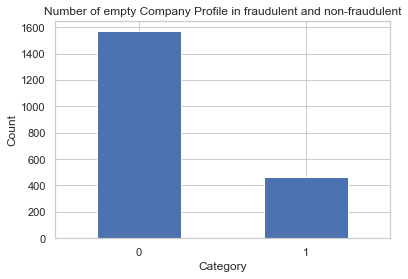

0

In [38]:
missing_count('company_profile', 'Company Profile')

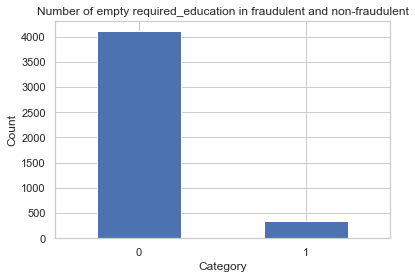

0

In [39]:
missing_count('required_education', 'required_education')

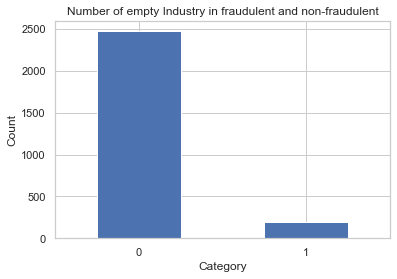

0

In [40]:
missing_count('industry', 'Industry')

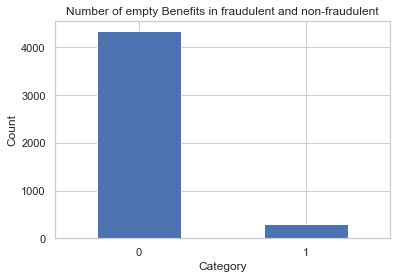

0

In [41]:
missing_count('benefits', 'Benefits')

In [42]:
telecommuting_list = []
has_company_logo_list = []

for idx, tel, logo in zip(range(len(fake_job_postings_US)), fake_job_postings_US.telecommuting, fake_job_postings_US.has_company_logo):
    if fake_job_postings.fraudulent[idx] == 1:
        telecommuting_list.append(tel)
        has_company_logo_list.append(logo)
    else:
        pass

telecommuting_logo_df = pd.DataFrame({'telecommuting':telecommuting_list, 'has_company_logo':has_company_logo_list})

In [43]:
fake_count = 0

for fraud, tel, logo in zip(fake_job_postings_US.fraudulent, fake_job_postings_US.telecommuting, fake_job_postings_US.has_company_logo):
    if (tel == 0 and logo == 0):
        if (fraud == 1):
            fake_count +=1
        else:
            pass
    else:
        pass


print(fake_count)

425


In [44]:
fake_count = 0

for fraud, tel, logo, ques in zip(fake_job_postings_US.fraudulent, fake_job_postings_US.telecommuting, fake_job_postings_US.has_company_logo, fake_job_postings_US.has_questions):
    if (tel == 0):# and logo == 0 and ques == 0):
        if (fraud == 1):
            fake_count +=1
        else:
            pass
    else:
        pass


print(fake_count)

667


In [45]:
len(fake_job_postings_US[fake_job_postings_US.fraudulent == 1])


725

In [46]:
667/725

0.92

In [47]:
fake_count/len(fake_job_postings_US[fake_job_postings_US.fraudulent == 1]) * 100

92.0

In [53]:
fake_job_postings_US.fillna(" ",inplace = True)

fake_job_postings_US['text'] =  fake_job_postings_US['title'] + ' ' + fake_job_postings_US['location'] + ' ' + fake_job_postings_US['company_profile'] + ' ' + \
        fake_job_postings_US['description'] + ' ' + fake_job_postings_US['requirements'] + ' ' + fake_job_postings_US['benefits'] + ' ' + \
        fake_job_postings_US['required_experience'] + ' ' + fake_job_postings_US['required_education'] + ' ' + fake_job_postings_US['industry'] + ' ' + fake_job_postings_US['function']


fake_job_postings_US.drop(['job_id', 'department', 'salary_range', 'title','location','department','company_profile','description','requirements','benefits','employment_type','required_experience','required_education','industry','function', 'city', 'state_city', 'has_company_logo', 'has_questions', 'state'], axis = 1, inplace = True)
fake_job_postings_US

,telecommuting,fraudulent,ratio,text
0,0,0,0.03,"Marketing Intern US, NY, New York We're Food52..."
1,0,0,0.03,"Visual Designer US, NY, New York Kettle is an ..."
2,0,0,0.03,"Payroll Tax Specialist US, NY, New York Namely..."
3,0,0,0.03,"Marketing Manager US, NY, New York Super Socce..."
4,0,0,0.03,"English Teacher Abroad US, NY, New York We hel..."
...,...,...,...,...
10588,1,1,0.00,"Military Benefits Counselor US, , chicago Anth..."
10589,0,0,0.00,Sr.Business Intelligence Technical Architect U...
10590,0,0,0.00,Licensed Practical Nurse (LPN)- Private Duty U...
10591,0,0,0.00,"SAS Grid Developer US, NJ, Berkeley Heights ..."


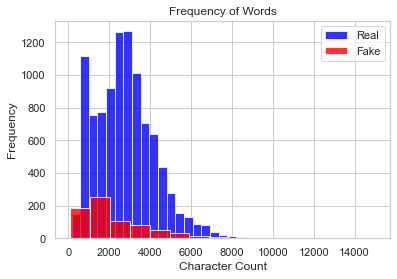

In [54]:
fake_job_postings_US['character_count'] = fake_job_postings_US.text.apply(len)

fake_job_postings_US[fake_job_postings_US.fraudulent==0].character_count.plot(bins=35, kind='hist', color='blue', 
                                       label='Real', alpha=0.8)
fake_job_postings_US[fake_job_postings_US.fraudulent==1].character_count.plot(kind='hist', color='red', 
                                       label='Fake', alpha=0.8)
plt.legend()
plt.title('Frequency of Words')
plt.xlabel("Character Count");

In [55]:
fake_job_postings_US

,telecommuting,fraudulent,ratio,text,character_count
0,0,0,0.03,"Marketing Intern US, NY, New York We're Food52...",2705
1,0,0,0.03,"Visual Designer US, NY, New York Kettle is an ...",1991
2,0,0,0.03,"Payroll Tax Specialist US, NY, New York Namely...",1564
3,0,0,0.03,"Marketing Manager US, NY, New York Super Socce...",2871
4,0,0,0.03,"English Teacher Abroad US, NY, New York We hel...",669
...,...,...,...,...,...
10588,1,1,0.00,"Military Benefits Counselor US, , chicago Anth...",1173
10589,0,0,0.00,Sr.Business Intelligence Technical Architect U...,1270
10590,0,0,0.00,Licensed Practical Nurse (LPN)- Private Duty U...,2124
10591,0,0,0.00,"SAS Grid Developer US, NJ, Berkeley Heights ...",1540


# Text Analysis

In [56]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [90]:
fake_job_postings_US.isna().sum()

telecommuting      0
fraudulent         0
ratio              0
text               0
character_count    0
dtype: int64

In [57]:
text = fake_job_postings_US.text.to_list()
text = ' '.join(text)
tokens_text = word_tokenize(text)

In [58]:
lower_tokens = [t.lower() for t in tokens_text]
word_freq = Counter(lower_tokens)
print(Counter.most_common(word_freq, 10))

[(',', 248535), ('and', 217648), ('to', 122839), ('the', 109316), ('.', 105141), ('of', 86304), ('a', 79623), ('in', 69803), ('with', 52166), ('for', 49747)]


In [59]:

text_only_alphabets = [t for t in lower_tokens if t.isalpha()]

In [60]:
english_stopped = stopwords.words('english')
no_stops = [t for t in text_only_alphabets if t not in english_stopped]

In [63]:
import nltk
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
bow = Counter(lemmatized)
print(Counter.most_common(bow, 10))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...


[('service', 22305), ('experience', 22275), ('work', 20784), ('customer', 19039), ('team', 18648), ('company', 17227), ('u', 17064), ('business', 13857), ('client', 13009), ('sale', 11779)]


# Model Building

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


In [72]:
fake_job_postings_US.shape

(10593, 5)

In [73]:
fake_job_postings = pd.read_csv('fake_job_postings_cleaned.csv')

In [74]:
X = fake_job_postings[['telecommuting', 'ratio', 'text', 'character_count']]
y = fake_job_postings['fraudulent']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [76]:
X_train_num = X_train[['telecommuting', 'ratio', 'character_count']]
X_test_num = X_test[['telecommuting', 'ratio', 'character_count']]


In [77]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.text.values)
count_test = count_vectorizer.transform(X_test.text.values)

In [78]:

tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=1)
tfidf_train = tfidf_vectorizer.fit_transform(X_train.text)
tfidf_test = tfidf_vectorizer.transform(X_test.text)

In [79]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

In [80]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, pred)

0.971395881006865

In [81]:
metrics.f1_score(y_test, pred)

0.7435897435897436

In [82]:
from sklearn.linear_model import SGDClassifier

clf_log = SGDClassifier(loss='log').fit(count_train, y_train)
pred_log = clf_log.predict(count_test)
metrics.accuracy_score(y_test, pred_log)

0.9742562929061785

In [83]:
clf_num = SGDClassifier(loss='log').fit(X_train_num, y_train)
pred_num = clf_num.predict(X_test_num)
metrics.accuracy_score(y_test, pred_num)

0.9339244851258581

In [84]:
prediction_array = []

for i, j in zip(pred_num, pred_log):
    if i == 0 and j == 0:
        prediction_array.append(0)
    else:
        prediction_array.append(1)

In [85]:
metrics.accuracy_score(y_test, prediction_array)

0.9742562929061785

In [86]:
metrics.f1_score(y_test, prediction_array)

0.792626728110599

In [87]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, prediction_array)

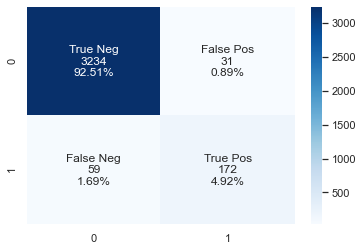

In [88]:
group_names = ["True Neg","False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');


In [89]:
len(y_test[y_test == 0]), len(y_test[y_test == 1])

(3265, 231)